In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from scipy.stats import scoreatpercentile
import matplotlib.pyplot as plt
from itertools import product
import json

pd.set_option('display.max_columns', 30)
plt.ioff()

import warnings

# Suppress all UserWarnings (you can be more specific by filtering warnings)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
train = pd.read_csv("train_data_0322.csv").drop(columns = ['Unnamed: 0', 'id'], axis = 1)
test = pd.read_csv("test_data_0322.csv").drop(columns = ['Unnamed: 0', 'id'], axis = 1)

train = pd.get_dummies(train, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

X_train = train.drop(columns = ['price'], axis = 1)
y_train = train['price']

X_test = test.drop(columns = ['price'], axis = 1)
y_test = test['price']

In [12]:
# Notice that we use absolute values due to the possibility of 'quantile crossing' where lower > upper.

def WIS_and_coverage(y_true,lower,upper,alpha = 0.2):

    assert np.isnan(y_true) == False, "y_true contains NaN value(s)"
    assert np.isinf(y_true) == False, "y_true contains inf values(s)"
    assert np.isnan(lower)  == False, "lower interval value contains NaN value(s)"
    assert np.isinf(lower)  == False, "lower interval value contains inf values(s)"
    assert np.isnan(upper)  == False, "upper interval value contains NaN value(s)"
    assert np.isinf(upper)  == False, "upper interval value contains inf values(s)"
    assert alpha > 0 and alpha <= 1,  f"alpha should be (0,1]. Found: {alpha}"

    # WIS for one single row
    score = np.abs(upper-lower)
    if y_true < np.minimum(upper,lower):
        score += ((2/alpha) * (np.minimum(upper,lower) - y_true))
    if y_true > np.maximum(upper,lower):
        score += ((2/alpha) * (y_true - np.maximum(upper,lower)))
    # coverage for one single row
    coverage  = 1 # assume is within coverage
    if (y_true < np.minimum(upper,lower)) or (y_true > np.maximum(upper,lower)):
        coverage = 0
    return score, coverage

# vectorize the function
v_WIS_and_coverage = np.vectorize(WIS_and_coverage)

def score(y_true,lower,upper,alpha):
    """
    This is an implementation of the Winkler Interval score (https://otexts.com/fpp3/distaccuracy.html#winkler-score).
    The mean over all of the individual Winkler Interval scores (MWIS) is returned, along with the coverage.

    See:
    [1] Robert L. Winkler "A Decision-Theoretic Approach to Interval Estimation", Journal of the American Statistical Association, vol. 67, pp. 187-191 (1972) (https://doi.org/10.1080/01621459.1972.10481224)
    [2] Tilmann Gneiting and Adrian E Raftery "Strictly Proper Scoring Rules, Prediction, and Estimation", Journal of the American Statistical Association, vol. 102, pp. 359-378 (2007) (https://doi.org/10.1198/016214506000001437) (Section 6.2)

    Version: 1.0.4
    Author:  Carl McBride Ellis
    Date:    2023-12-07
    """

    assert y_true.ndim == 1, "y_true: pandas Series or 1D array expected"
    assert lower.ndim  == 1, "lower: pandas Series or 1D array expected"
    assert upper.ndim  == 1, "upper: pandas Series or 1D array expected"
    assert isinstance(alpha, float) == True, "alpha: float expected"

    WIS_scores, coverage = v_WIS_and_coverage(y_true,lower,upper,alpha)
    MWIS      = np.mean(WIS_scores)
    MWIS      = float(MWIS)
    coverage  = coverage.sum()/coverage.shape[0]
    coverage  = float(coverage)

    return MWIS,coverage

def get_quantile_predictions(model, X, quantile):
    """
    Calculate the lower and upper quantiles from the individual tree predictions in a RandomForest.

    Parameters:
    - model: Trained RandomForest model
    - X: Input features (test set)
    - lower_quantile: Desired lower quantile (e.g., 10th percentile)
    - upper_quantile: Desired upper quantile (e.g., 90th percentile)

    Returns:
    - lower_estimate: Lower quantile estimate for each instance
    - upper_estimate: Upper quantile estimate for each instance
    """
    # Get individual tree predictions (one per estimator)
    tree_predictions = np.array([tree.predict(X) for tree in model.estimators_]).T  # Shape: (n_samples, n_estimators)

    # Calculate the quantiles for each instance across the trees
    lower_estimate = np.percentile(tree_predictions, quantile, axis=1)
    upper_estimate = np.percentile(tree_predictions, 100 - quantile, axis=1)

    return lower_estimate, upper_estimate


In [35]:
%%time
model = RandomForestRegressor(n_estimators = 200, max_depth = None)
model.fit(X_train, y_train)

CPU times: total: 2min 33s
Wall time: 2min 41s


RandomForestRegressor(n_estimators=200)

In [26]:
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

In [45]:
quantiles = np.linspace(1, 25, 12)

winkler_scores = {quantile : 0 for quantile in quantiles}
maes = {quantile : 0 for quantile in quantiles}
coverage_scores = {quantile : 0 for quantile in quantiles}

for quantile in tqdm(quantiles):
    lower_estimate, upper_estimate = get_quantile_predictions(model, X_test, quantile)
    MWIS,coverage = score(y_test,lower_estimate,upper_estimate, 0.2)
    winkler_scores[quantile] = MWIS
    coverage_scores[quantile] = coverage

100%|██████████| 24/24 [01:00<00:00,  2.53s/it]


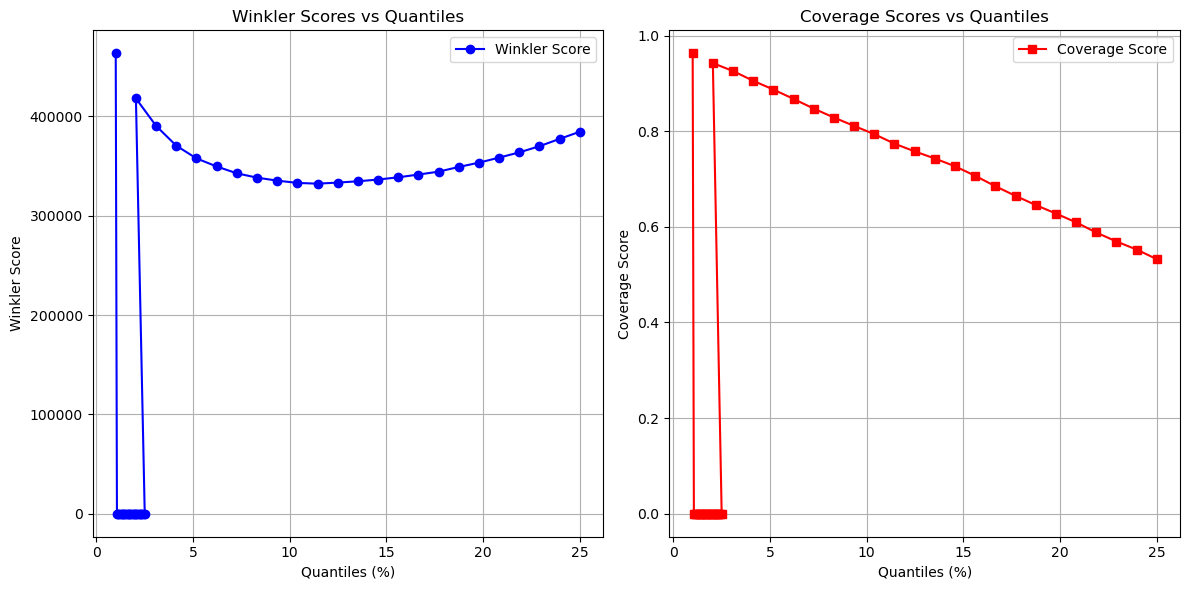

In [46]:
# Plotting Winkler Scores vs Quantiles
plt.figure(figsize=(12, 6))

# Plot for Winkler scores (Quantiles vs MWIS)
plt.subplot(1, 2, 1)
plt.plot(list(winkler_scores.keys()), list(winkler_scores.values()), marker='o', color='b', label='Winkler Score')
plt.title('Winkler Scores vs Quantiles')
plt.xlabel('Quantiles (%)')
plt.ylabel('Winkler Score')
plt.grid(True)
plt.legend()

# Plotting Coverage Scores vs Quantiles
plt.subplot(1, 2, 2)
plt.plot(list(coverage_scores.keys()), list(coverage_scores.values()), marker='s', color='r', label='Coverage Score')
plt.title('Coverage Scores vs Quantiles')
plt.xlabel('Quantiles (%)')
plt.ylabel('Coverage Score')
plt.grid(True)
plt.legend()

# Display the plots
plt.tight_layout()
plt.savefig("my_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Grid search

In [54]:
# Define param_grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Generate all possible combinations of hyperparameters
keys = param_grid.keys()
values = param_grid.values()
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Print the first few model specifications
for i, spec in enumerate(param_combinations[:5]):  # Show first 5 only
    print(f"Model {i+1}: {spec}")

# Get total number of models
print(f"Total models to try: {len(param_combinations)}")


Model 1: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
Model 2: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Model 3: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
Model 4: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}
Model 5: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Total models to try: 216


In [66]:
results = ["SUMMARY\nPerformance of the best performing model for different configurations:\n\n"]

for i, model_spec in enumerate(tqdm(param_combinations)):
    # Initialize model with current hyperparameters
    model = RandomForestRegressor(**model_spec, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    quantiles = np.linspace(1, 25, 12).astype(int)

    winkler_scores = {quantile : 0 for quantile in quantiles}
    maes = {quantile : 0 for quantile in quantiles}
    coverage_scores = {quantile : 0 for quantile in quantiles}
    
    for quantile in quantiles:
        lower_estimate, upper_estimate = get_quantile_predictions(model, X_test, quantile)
        MWIS,coverage = score(y_test,lower_estimate,upper_estimate, 0.2)
        winkler_scores[quantile] = MWIS
        coverage_scores[quantile] = coverage

    best_quantile = min(winkler_scores, key=winkler_scores.get)

    results.append(f"\nWith specification {model_spec}, the best Winkler score is obtained at {best_quantile}% with Winkler score of {winkler_scores[best_quantile]}, with accuracy {coverage_scores[best_quantile]}.")
    
    # Plotting Winkler Scores vs Quantiles
    plt.figure(figsize=(12, 6))
    
    # Plot for Winkler scores (Quantiles vs MWIS)
    plt.subplot(1, 2, 1)
    plt.plot(list(winkler_scores.keys()), list(winkler_scores.values()), marker='o', color='b', label='Winkler Score')
    plt.title('Winkler Scores vs Quantiles')
    plt.xlabel('Quantiles (%)')
    plt.ylabel('Winkler Score')
    plt.grid(True)
    plt.legend()
    
    # Plotting Coverage Scores vs Quantiles
    plt.subplot(1, 2, 2)
    plt.plot(list(coverage_scores.keys()), list(coverage_scores.values()), marker='s', color='r', label='Coverage Score')
    plt.title('Coverage Scores vs Quantiles')
    plt.xlabel('Quantiles (%)')
    plt.ylabel('Coverage Score')
    plt.grid(True)
    plt.legend()

    # Convert model_spec dictionary to a shorter filename-friendly format
    safe_model_spec = json.dumps(model_spec, separators=("_", "_"))  # Compact format
    safe_model_spec = safe_model_spec.replace('"', "").replace("{", "").replace("}", "").replace(":", "").replace(",", "").replace(" ", "").replace("null", "None").replace("estimators", "est")
    
    filename = f"model_{i}_{safe_model_spec}.png"
    
    # Display the plots
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

with open("results.txt", "w") as f:
    for line in results:
        f.write(line + "\n")  # Add newline after each string

print("Results saved to results.txt")

100%|██████████| 216/216 [1:00:05<00:00, 16.69s/it]

Results saved to results.txt


In [70]:
best_spec = "'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'"

In [72]:
best_model = RandomForestRegressor(n_estimators = 400, max_depth = None, min_samples_split = 2, min_samples_leaf = 1, max_features = 'log2')

In [74]:
%%time
best_model.fit(X_train, y_train)

CPU times: total: 53.9 s
Wall time: 58.3 s


RandomForestRegressor(max_features='log2', n_estimators=400)

100%|██████████| 25/25 [00:56<00:00,  2.28s/it]


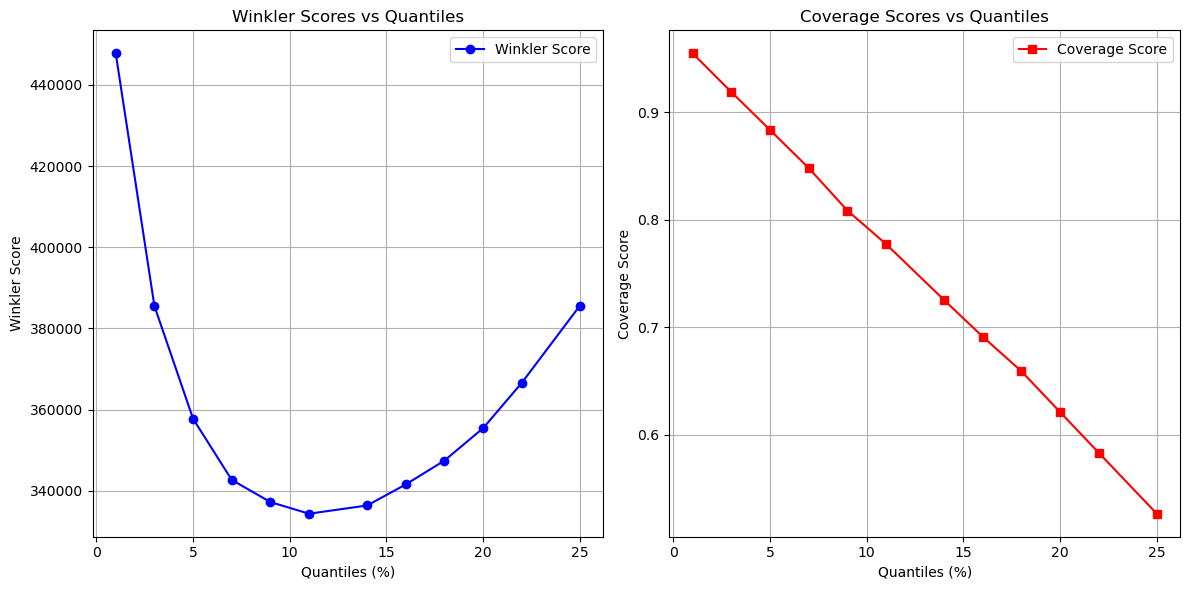

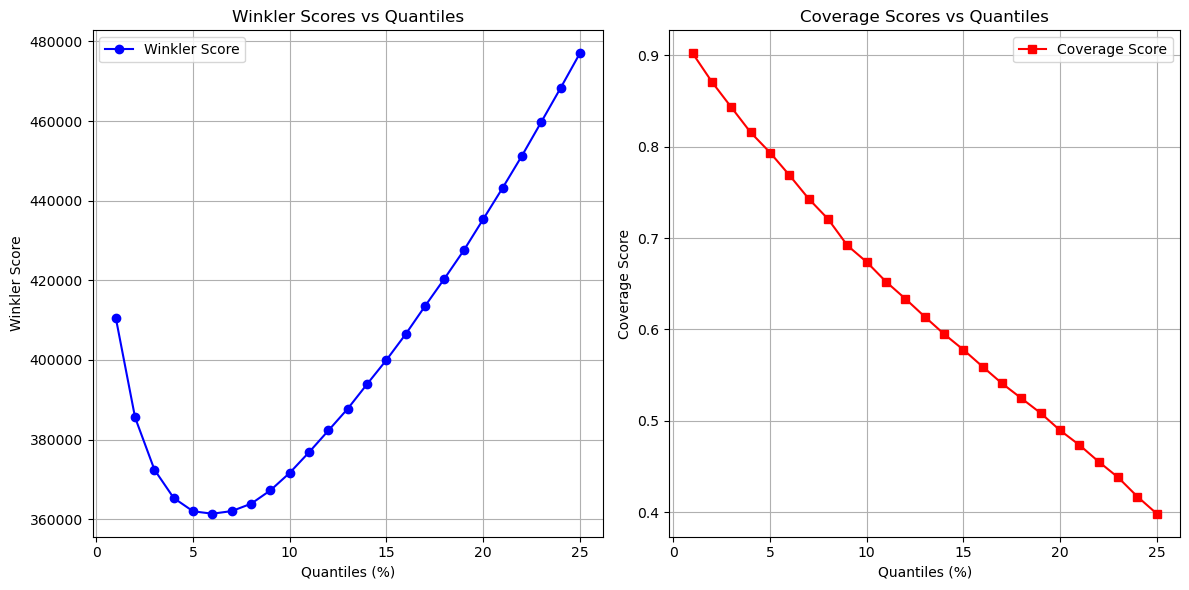

6


In [76]:
quantiles = np.linspace(1, 25, 25).astype(int)

winkler_scores = {quantile : 0 for quantile in quantiles}
maes = {quantile : 0 for quantile in quantiles}
coverage_scores = {quantile : 0 for quantile in quantiles}

for quantile in tqdm(quantiles):
    lower_estimate, upper_estimate = get_quantile_predictions(model, X_test, quantile)
    MWIS,coverage = score(y_test,lower_estimate,upper_estimate, 0.2)
    winkler_scores[quantile] = MWIS
    coverage_scores[quantile] = coverage

best_quantile = min(winkler_scores, key=winkler_scores.get)

#results.append(f"\nWith specification {model_spec}, the best Winkler score is obtained at {best_quantile}% with Winkler score of {winkler_scores[best_quantile]}, with accuracy {coverage_scores[best_quantile]}.")

# Plotting Winkler Scores vs Quantiles
plt.figure(figsize=(12, 6))

# Plot for Winkler scores (Quantiles vs MWIS)
plt.subplot(1, 2, 1)
plt.plot(list(winkler_scores.keys()), list(winkler_scores.values()), marker='o', color='b', label='Winkler Score')
plt.title('Winkler Scores vs Quantiles')
plt.xlabel('Quantiles (%)')
plt.ylabel('Winkler Score')
plt.grid(True)
plt.legend()

# Plotting Coverage Scores vs Quantiles
plt.subplot(1, 2, 2)
plt.plot(list(coverage_scores.keys()), list(coverage_scores.values()), marker='s', color='r', label='Coverage Score')
plt.title('Coverage Scores vs Quantiles')
plt.xlabel('Quantiles (%)')
plt.ylabel('Coverage Score')
plt.grid(True)
plt.legend()

# Display the plots
plt.tight_layout()
plt.savefig("best_model.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(best_quantile)